In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("fintech_transactions_10k.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [3]:
df.head(5)

,transaction_id,customer_id,transaction_date,transaction_amount,transaction_type,merchant_id,device_type,location,channel,account_balance,is_fraud
0,3b31ac4d-4f6a-4926-9982-dda852a1db7a,CUST49044,2024-11-07 11:14:53.833131,5.05,POS,MER6478,Mobile,Vadodara,UPI,21143.67,0
1,32339b12-a271-4fd8-879c-7e3d45eb691a,CUST74120,2024-11-07 11:30:31.833131,38.45,POS,MER6101,Mobile,Indore,Debit Card,2076.98,0
2,2b5ad00d-dd83-41ef-9e8c-8c9bcbfbc330,CUST82125,2024-11-07 12:13:37.833131,82.64,Online,MER8597,Mobile,Mysuru,Net Banking,19001.74,0
3,1362c3c6-0042-4a82-8c35-56433716350b,CUST33112,2024-11-07 12:51:56.833131,52.23,Online,MER7532,Web,Kolkata,Credit Card,25664.13,0
4,983e67de-96ef-4769-a73d-b9022d35d8e6,CUST34523,2024-11-07 13:25:40.833131,22.33,POS,MER5778,Mobile,Coimbatore,Credit Card,44023.02,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      10000 non-null  object        
 1   customer_id         10000 non-null  object        
 2   transaction_date    10000 non-null  datetime64[ns]
 3   transaction_amount  10000 non-null  float64       
 4   transaction_type    10000 non-null  object        
 5   merchant_id         10000 non-null  object        
 6   device_type         10000 non-null  object        
 7   location            10000 non-null  object        
 8   channel             10000 non-null  object        
 9   account_balance     10000 non-null  float64       
 10  is_fraud            10000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 859.5+ KB


In [22]:
df.isnull().sum

<bound method DataFrame.sum of       transaction_id  customer_id  transaction_date  transaction_amount  \
0              False        False             False               False   
1              False        False             False               False   
2              False        False             False               False   
3              False        False             False               False   
4              False        False             False               False   
...              ...          ...               ...                 ...   
9995           False        False             False               False   
9996           False        False             False               False   
9997           False        False             False               False   
9998           False        False             False               False   
9999           False        False             False               False   

      transaction_type  merchant_id  device_type  location  channel 

In [4]:
# Convert date if exists
if "transaction_date" in df.columns:
    df["transaction_date"] = pd.to_datetime(df["transaction_date"])

In [11]:
# Load to SQL
conn = sqlite3.connect("fraud_eda.sqlite")
df.to_sql("txn", conn, if_exists="replace", index=False)

10000

In [15]:
# Helper function to run SQL
def run(q):
    return pd.read_sql(q, conn)

# 1. What is the overall fraud rate?

In [16]:
q1 = "SELECT COUNT(*) total, SUM(is_fraud) frauds, ROUND(100.0*SUM(is_fraud)/COUNT(*),2) fraud_percent FROM txn"
print(run(q1))

   total  frauds  fraud_percent
0  10000     578           5.78


# 2. Which transaction types and devices have highest fraud?

In [17]:
print(run("SELECT transaction_type, SUM(is_fraud) frauds FROM txn GROUP BY transaction_type ORDER BY frauds DESC LIMIT 5"))

print(run("SELECT device_type, SUM(is_fraud) frauds FROM txn GROUP BY device_type ORDER BY frauds DESC LIMIT 5"))

  transaction_type  frauds
0           Online     291
1              POS     148
2         Transfer      91
3              ATM      48
  device_type  frauds
0      Mobile     334
1         Web     164
2         ATM      54
3         POS      26


# 3. What are high-risk customers and locations?

In [18]:

print(run("SELECT customer_id, COUNT(*) total, SUM(is_fraud) frauds FROM txn WHERE is_fraud=1 GROUP BY customer_id ORDER BY frauds DESC LIMIT 5"))

print(run("SELECT location, COUNT(*) total, SUM(is_fraud) frauds FROM txn WHERE is_fraud=1 GROUP BY location ORDER BY frauds DESC LIMIT 5"))

  customer_id  total  frauds
0   CUST65770      2       2
1   CUST99893      1       1
2   CUST99787      1       1
3   CUST99671      1       1
4   CUST99648      1       1
        location  total  frauds
0         Mysuru     34      34
1        Kolkata     33      33
2  Visakhapatnam     31      31
3      Bengaluru     28      28
4         Indore     27      27


# 4. Are certain times more prone to fraud?


In [24]:
print(run("""
SELECT strftime('%H', transaction_date) hour, SUM(is_fraud) frauds 
FROM txn GROUP BY hour ORDER BY frauds DESC LIMIT 5
"""))

  hour  frauds
0   05      38
1   02      33
2   19      32
3   17      31
4   11      29


# 5. Which device type or channel is most risky?

In [25]:
print(run("SELECT device_type, channel, SUM(is_fraud) frauds FROM txn GROUP BY device_type, channel ORDER BY frauds DESC LIMIT 5"))


  device_type      channel  frauds
0      Mobile          UPI     177
1         Web          UPI      90
2      Mobile   Debit Card      69
3      Mobile  Credit Card      61
4         Web   Debit Card      31


# 6. Which customers have the most frauds?

In [26]:
print(run("SELECT customer_id, SUM(is_fraud) frauds FROM txn GROUP BY customer_id ORDER BY frauds DESC LIMIT 10"))


  customer_id  frauds
0   CUST65770       2
1   CUST99893       1
2   CUST99787       1
3   CUST99671       1
4   CUST99648       1
5   CUST99640       1
6   CUST99368       1
7   CUST99276       1
8   CUST99223       1
9   CUST98848       1


# 7. Which merchants or regions have repeated suspicious activity?

In [27]:
print(run("SELECT merchant_id, SUM(is_fraud) frauds FROM txn GROUP BY merchant_id HAVING frauds > 1 ORDER BY frauds DESC LIMIT 5"))

print(run("SELECT location, SUM(is_fraud) frauds FROM txn GROUP BY location HAVING frauds > 1 ORDER BY frauds DESC LIMIT 5"))


  merchant_id  frauds
0     MER9990       2
1     MER9567       2
2     MER9476       2
3     MER9382       2
4     MER8378       2
        location  frauds
0         Mysuru      34
1        Kolkata      33
2  Visakhapatnam      31
3      Bengaluru      28
4         Indore      27


# 8. Is there a specific time/day when fraud occurs most?

In [28]:
# By hour
print(run("SELECT strftime('%H', transaction_date) hour, SUM(is_fraud) frauds FROM txn GROUP BY hour ORDER BY frauds DESC"))

# By day
df['day'] = df['transaction_date'].dt.day_name()
df.to_sql("txn", conn, if_exists="replace", index=False)
print(run("SELECT day, SUM(is_fraud) frauds FROM txn GROUP BY day ORDER BY frauds DESC"))


   hour  frauds
0    05      38
1    02      33
2    19      32
3    17      31
4    11      29
5    09      27
6    01      26
7    00      26
8    12      25
9    14      24
10   22      23
11   06      23
12   04      23
13   03      23
14   23      22
15   15      22
16   13      21
17   21      20
18   08      20
19   07      20
20   20      19
21   10      18
22   18      17
23   16      16
         day  frauds
0  Wednesday      96
1     Sunday      88
2   Thursday      81
3   Saturday      80
4     Monday      80
5     Friday      78
6    Tuesday      75


# 9. Are high-value transactions more likely to be fraudulent?

In [29]:
hv = df['transaction_amount'].quantile(0.95)
print("High Value Threshold:", hv)

print(run(f"""
SELECT 
  SUM(CASE WHEN transaction_amount >= {hv} THEN 1 END) AS high_value_txn,
  SUM(CASE WHEN transaction_amount >= {hv} AND is_fraud=1 THEN 1 END) AS high_value_frauds
FROM txn
"""))


High Value Threshold: 166.07149999999996
   high_value_txn  high_value_frauds
0             500                 31


# 10. Which locations have the highest fraud density?

        location  total  frauds  fraud_rate
0         Mysuru    395      34        8.61
1        Kolkata    402      33        8.21
2  Visakhapatnam    431      31        7.19
3      Bengaluru    410      28        6.83
4          Noida    389      25        6.43
5         Indore    425      27        6.35
6          Thane    404      25        6.19
7       Gurugram    401      24        5.99
8         Mumbai    374      22        5.88
9          Surat    412      24        5.83


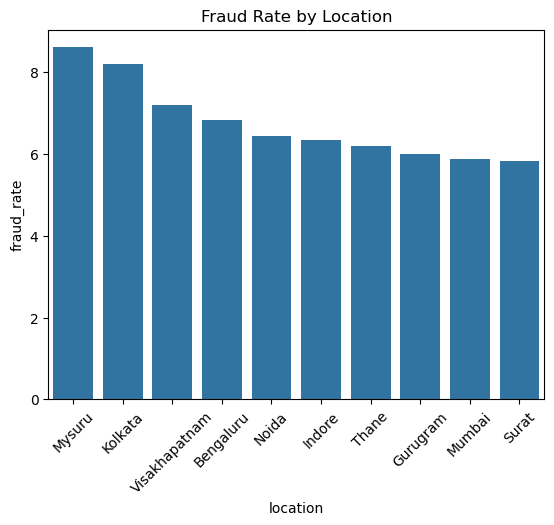

In [30]:
loc = run("SELECT location, COUNT(*) total, SUM(is_fraud) frauds, ROUND(100.0*SUM(is_fraud)/COUNT(*),2) fraud_rate FROM txn GROUP BY location ORDER BY fraud_rate DESC LIMIT 10")
print(loc)

sns.barplot(x=loc["location"], y=loc["fraud_rate"])
plt.xticks(rotation=45)
plt.title("Fraud Rate by Location")
plt.show()
